In [68]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/sod'

# Set path to be the directory:
os.chdir(path)

In [70]:
# Read the list of county codes:
cw = pd.read_excel('qcew-county-msa-csa-crosswalk.xlsx', sheet_name='Feb. 2013 Crosswalk')

cw['STCNTYBR'] = cw['County Code'].astype(str)
cw.loc[cw['STCNTYBR'].str.len() == 4, 'STCNTYBR'] = '0' + cw['STCNTYBR']

In [71]:
# Load branch data:
sod = pd.read_csv('sod_data.csv', header=0, sep=',')
#inst = pd.read_csv('sod_data_ins.csv', header=0, sep=',')

C:\Users\angel\AppData\Local\Temp\ipykernel_24740\2809252724.py:2: DtypeWarning: Columns (13,28,50,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  sod = pd.read_csv('sod_data.csv', header=0, sep=',')


In [72]:
sod['STCNTYBR'] = sod['STCNTYBR'].astype(str)
sod.loc[sod['STCNTYBR'].str.len() == 4, 'STCNTYBR'] = '0' + sod['STCNTYBR']

In [73]:
# Merge 'list' on 'STCNTYBR' with the sod data:
sod = pd.merge(sod, cw, on='STCNTYBR', how='left')

In [74]:
# show columns 13,28,50,59,60,62:
cols = [13,28,50,59,60,62]

# Specify dtypes for col 13, 28, 50, 59, 60, 62:
sod.iloc[:,cols].dtypes

DEPSUMBR    object
NECNAMB     object
ASSET       object
DEPDOM      object
DEPSUM      object
ESCROW      object
dtype: object

In [75]:
# Take commas away from columns 13, 28, 50, 59, 60, 62 so we can convert them to numeric:
sod.iloc[:,cols] = sod.iloc[:,cols].replace(',', '', regex=True)
#inst.iloc[:,cols] = inst.iloc[:,cols].replace(',', '', regex=True)

In [76]:
# Convert DEPSUMBR to numeric:
sod['DEPSUMBR'] = pd.to_numeric(sod['DEPSUMBR'], errors='coerce')

In [77]:
# Value in USD 
print('Deposits in 1996:', sod[sod['YEAR']==1996]['DEPSUMBR'].sum())

# Take the totals for every year and send to Jason. 

Deposits in 1996: 3328302607


In [78]:
# Create dataset excluding the HQ and NaN for the MSA Title:
df = sod[(sod['BKMO']==0) & (sod['MSA Title'].notnull())]

In [79]:
# Aggregate deposits over MSA per year, it will be useful later...
df_grouped_msa = df.groupby(['MSA Title', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_msa')

# Aggregate all deposits over US per year:
df_grouped_msa['total_US'] = df_grouped_msa.groupby('YEAR')['total_msa'].transform('sum')

# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [80]:
# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [81]:
# Sanity check, sum of share_msa per year should be 1:
df_grouped_msa.groupby('YEAR')['share_msa'].sum()

YEAR
1994    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
2000    1.0
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
Name: share_msa, dtype: float64

In [82]:
# This line is calculating the total deposits per MSANAMB and year (summing among all IDs). To see this run the following test:
print(df[(df['MSA Title']=='Orlando-Kissimmee-Sanford, FL') & (df['YEAR']==2022)]['DEPSUMBR'].sum())
df_grouped_msa[(df_grouped_msa['MSA Title']=='Orlando-Kissimmee-Sanford, FL') & (df_grouped_msa['YEAR']==2022)]
# Note that all rows have the same value for total.

0


,MSA Title,YEAR,total_msa,total_US,share_msa


In [83]:
# Compute the share of deposits per ID and year, note that the total deposits per MSANAMB is in the df_grouped dataset:
df = pd.merge(df, df_grouped_msa, on=['MSA Title', 'YEAR'], how='left')

# Sort values by MSA and year:
df = df.sort_values(by=['MSA Title', 'YEAR'])

In [84]:
# Create an ID variable that is equal to RSSDHCR, and if RSSDHCR==0 then ID=RSSDID:
df['ID'] = np.where(df['RSSDHCR']==0, df['RSSDID'], df['RSSDHCR']) 

In [85]:
df[df['ID']==0] # matches with jason until here

,YEAR,CERT,BRNUM,UNINUMBR,NAMEFULL,ADDRESBR,CITYBR,CNTYNAMB,STALPBR,ZIPBR,...,County Code,County Title,MSA Code,MSA Title,CSA Code,CSA Title,total_msa,total_US,share_msa,ID
454393,2000,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,25017.0,"Middlesex County, Massachusetts",C1446,"Boston-Cambridge-Newton, MA-NH MSA",CS148,"Boston-Worcester-Providence, MA-RI-NH-CT CSA",74864134,2720908939,0.027514,0
523466,2001,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,25017.0,"Middlesex County, Massachusetts",C1446,"Boston-Cambridge-Newton, MA-NH MSA",CS148,"Boston-Worcester-Providence, MA-RI-NH-CT CSA",73718798,2898566377,0.025433,0
523045,2001,34966,1,359307.0,First Capital Bank,1503 Atkinson St,Laurinburg,Scotland,NC,28352.0,...,37165.0,"Scotland County, North Carolina",C2990,"Laurinburg, NC MicroSA",CS246,"Fayetteville-Lumberton-Laurinburg, NC CSA",265636,2898566377,0.000092,0
592438,2002,34966,1,359307.0,First Capital Bank,909 S Main St,Laurinburg,Scotland,NC,28352.0,...,37165.0,"Scotland County, North Carolina",C2990,"Laurinburg, NC MicroSA",CS246,"Fayetteville-Lumberton-Laurinburg, NC CSA",278831,3107570722,0.000090,0
454392,2000,35329,1,290909.0,Beacon Federal,5248 Manchester Highway,Morrison,Warren,TN,37357.0,...,47177.0,"Warren County, Tennessee",C3266,"McMinnville, TN MicroSA",NaN,NaN,296897,2720908939,0.000109,0
523465,2001,35329,1,290909.0,Beacon Federal,5248 Manchester Highway,Morrison,Warren,TN,37357.0,...,47177.0,"Warren County, Tennessee",C3266,"McMinnville, TN MicroSA",NaN,NaN,304804,2898566377,0.000105,0
454394,2000,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,47157.0,"Shelby County, Tennessee",C3282,"Memphis, TN-MS-AR MSA",CS368,"Memphis-Forrest City, TN-MS-AR CSA",9874455,2720908939,0.003629,0
523467,2001,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,47157.0,"Shelby County, Tennessee",C3282,"Memphis, TN-MS-AR MSA",CS368,"Memphis-Forrest City, TN-MS-AR CSA",10484072,2898566377,0.003617,0
454391,2000,35329,4,290912.0,Beacon Federal,"509 Enon Springs Road East, Suite 1",Smyrna,Rutherford,TN,37167.0,...,47149.0,"Rutherford County, Tennessee",C3498,"Nashville-Davidson--Murfreesboro--Franklin, TN...",CS400,"Nashville-Davidson--Murfreesboro, TN CSA",15923725,2720908939,0.005852,0
523463,2001,35329,4,290912.0,Beacon Federal,105 Threet Industrial Road,Smyrna,Rutherford,TN,37167.0,...,47149.0,"Rutherford County, Tennessee",C3498,"Nashville-Davidson--Murfreesboro--Franklin, TN...",CS400,"Nashville-Davidson--Murfreesboro, TN CSA",15742913,2898566377,0.005431,0


In [86]:
# Compute the total amount of deposits per NAMEHCR, in each MSA and year:
df_grouped_id = df.groupby(['ID', 'MSA Title', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_id')

df = pd.merge(df, df_grouped_id, on=['ID', 'MSA Title', 'YEAR'], how='left')

In [87]:
# Compute share of deposits per NAMEHCR, in each MSA and year:
df['share_id'] = 100*(df['total_id']/df['total_msa'])
df['share_id_sq'] = df['share_id']**2


In [88]:
# Take the columns ID, YEAR, MSANAMB, and share_id_sq and take uniques on IDs, keep only those columns:
df_grouped_id_sq = df[['ID', 'YEAR', 'MSA Title','share_id_sq']].drop_duplicates()
 

In [89]:
# Sum all the share_id_sq per MSANAMB and year:
df_grouped_id_sq = df_grouped_id_sq.groupby(['MSA Title', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

In [90]:
df_grouped_id_sq[df_grouped_id_sq['HHI']==10000]

,MSA Title,YEAR,HHI
121,"Adjuntas, PR MicroSA",1995,10000.0
122,"Adjuntas, PR MicroSA",1996,10000.0
123,"Adjuntas, PR MicroSA",1997,10000.0
124,"Adjuntas, PR MicroSA",1998,10000.0
125,"Adjuntas, PR MicroSA",1999,10000.0
...,...,...,...
27833,"Zapata, TX MicroSA",2019,10000.0
27834,"Zapata, TX MicroSA",2020,10000.0
27835,"Zapata, TX MicroSA",2021,10000.0
27836,"Zapata, TX MicroSA",2022,10000.0


In [91]:
# sum the squared shares of deposits per MSA, per year:
df_HHI = df_grouped_id_sq[['YEAR', 'MSA Title', 'HHI']].drop_duplicates()

In [92]:
df_HHI = pd.merge(df_HHI, df_grouped_msa, on=['MSA Title', 'YEAR'], how='left')

In [93]:
df_HHI

,YEAR,MSA Title,HHI,total_msa,total_US,share_msa
0,1994,"Aberdeen, SD MicroSA",3786.198379,405845,2037957669,1.991430e-04
1,1995,"Aberdeen, SD MicroSA",3650.867342,417889,2109344069,1.981132e-04
2,1996,"Aberdeen, SD MicroSA",3686.833269,417102,2214427982,1.883565e-04
3,1997,"Aberdeen, SD MicroSA",3584.112504,424508,2333703942,1.819031e-04
4,1998,"Aberdeen, SD MicroSA",3254.563962,426297,2476478960,1.721383e-04
...,...,...,...,...,...,...
27833,2019,"Zapata, TX MicroSA",10000.000000,3403,8627738094,3.944255e-07
27834,2020,"Zapata, TX MicroSA",10000.000000,3947,10506314682,3.756788e-07
27835,2021,"Zapata, TX MicroSA",10000.000000,3287,11817134226,2.781554e-07
27836,2022,"Zapata, TX MicroSA",10000.000000,9244,12291297333,7.520768e-07


In [94]:
df_HHI[(df_HHI['YEAR']==1994) & (df_HHI['MSA Title']=='Orlando-Kissimmee-Sanford, FL')]

,YEAR,MSA Title,HHI,total_msa,total_US,share_msa


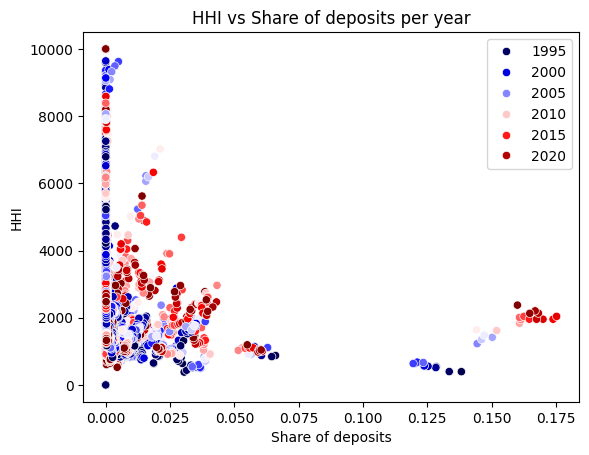

In [95]:
# plot a scatter plot of the HHI per share_msa per year, I want the dots for each year to have different collors, and 
# to be in different plots:
sns.scatterplot(data=df_HHI, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')
plt.savefig('HHI_vs_share_deposits.png')
plt.show()


Text(0, 0.5, 'HHI')

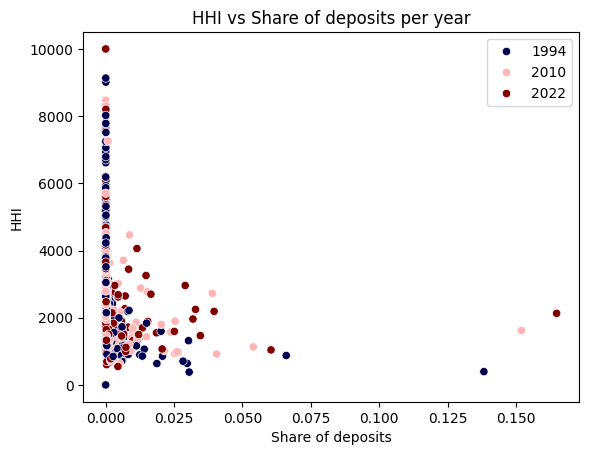

In [96]:
# I want to make the same plot as above, but only for 1994 and 2022:
df_HHI_1994_2022 = df_HHI[(df_HHI['YEAR']==1994) | (df_HHI['YEAR']==2010) | (df_HHI['YEAR']==2022)]

sns.scatterplot(data=df_HHI_1994_2022, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')


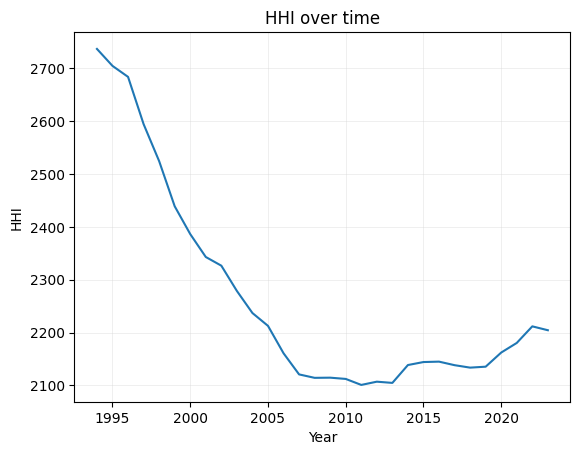

In [97]:
# Aggregate to get one HHI per year, averaging over MSAs:
df_HHI = df_HHI.groupby('YEAR')['HHI'].mean().reset_index(name='HHI')

# Plot HHI over time:
plt.plot(df_HHI['YEAR'], df_HHI['HHI'])
plt.xlabel('Year')
plt.ylabel('HHI')
plt.title('HHI over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('HHI_over_time.png')
plt.show()

In [98]:
# temporary dataset
temp = df[['ID', 'YEAR', 'MSA Title', 'share_id_sq', 'share_msa']].drop_duplicates()

# compute HHI per MSA and year
wHHI = temp.groupby(['MSA Title', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

df_wHHI = pd.merge(df[['MSA Title', 'YEAR', 'share_msa']], wHHI, on=['MSA Title', 'YEAR'], how='left').drop_duplicates()


In [99]:
# Average HHI over MSAs, weighting by 'share_msa' to get one value per year:
df_wHHI['wHHI'] = df_wHHI['HHI']*df_wHHI['share_msa']

# sum wHHI variable per year:
df_wHHI = df_wHHI.groupby('YEAR')['wHHI'].sum().reset_index(name='wHHI')


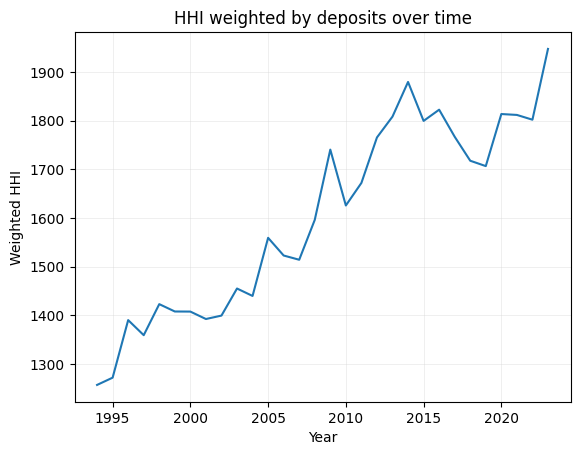

In [100]:
# plot wHHI over time:
plt.plot(df_wHHI['YEAR'], df_wHHI['wHHI'])
plt.xlabel('Year')
plt.ylabel('Weighted HHI')
plt.title('HHI weighted by deposits over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('wHHI_over_time.png')
plt.show()